- Dataset: https://www.kaggle.com/youssef2020/face-mask-detection-dataset
- Referenced: https://github.com/techtribeyt/cat_dog_classification/blob/master/nn_v1.py
- Referenced: https://www.youtube.com/watch?v=NoRXON3YJ_A

In [ ]:
!unzip /content/mask_data.zip

In [13]:
import numpy as np 
import pandas as pd 
import os

## Fit the Images

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# getting data
base_dir = 'mask_data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [16]:
train_dir

'mask_data/train'

In [17]:
validation_dir

'mask_data/validation'

In [18]:
train_with_mask = os.path.join(train_dir, 'with_mask')
train_without_mask = os.path.join(train_dir, 'without_mask')

In [19]:
validation_with_mask = os.path.join(validation_dir, 'with_mask')
validation_without_mask = os.path.join(validation_dir, 'without_mask')

In [20]:
num_mask_tr = len(os.listdir(train_with_mask))
num_without_mask_tr = len(os.listdir(train_without_mask))
num_mask_val = len(os.listdir(validation_with_mask))
num_without_mask_val = len(os.listdir(validation_without_mask))

In [21]:
total_train = num_mask_tr + num_without_mask_tr
total_val = num_mask_val + num_without_mask_val

BATCH_SIZE = 32
IMG_SHAPE = 150 # square image. 150x150 pixel

## Create Image Generator

In [22]:
## to show image
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [23]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

In [24]:
validation_image_generator = ImageDataGenerator(
    rescale=1./255)

In [25]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True, ## random
                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                                           class_mode='binary')

Found 7153 images belonging to 2 classes.


In [26]:
val_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=validation_dir,
                                                           shuffle=False,## not random
                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                                           class_mode='binary')

Found 400 images belonging to 2 classes.


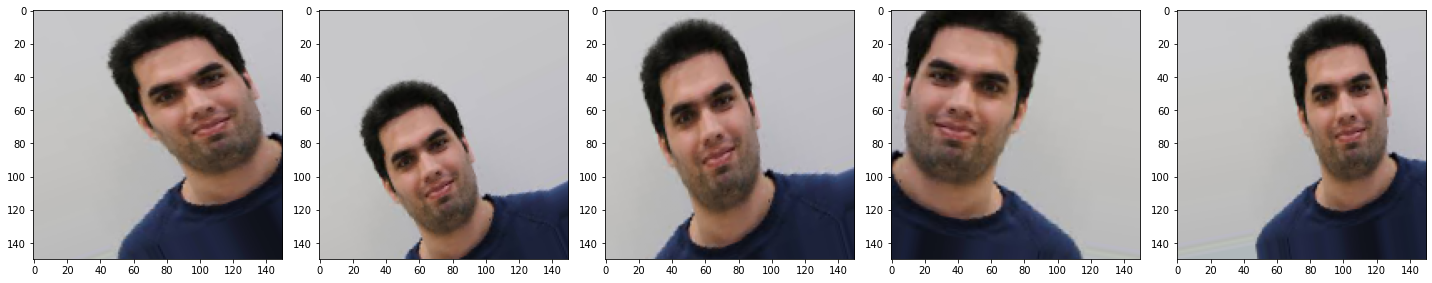

In [39]:
images = [train_data_gen[0][0][1] for i in range(5)]
plotImages(images)

## Train Model

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)), # RGB
    tf.keras.layers.MaxPooling2D(2,2),  
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               2

In [30]:
model.fit(train_data_gen, epochs=10)

Epoch 1/10
 61/224 [=======>......................] - ETA: 42s - loss: 1.8854 - accuracy: 0.5993

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


224/224 [==============================] - 89s 264ms/step - loss: 1.0170 - accuracy: 0.7128
Epoch 2/10
224/224 [==============================] - 61s 271ms/step - loss: 0.4247 - accuracy: 0.8114
Epoch 3/10
224/224 [==============================] - 61s 273ms/step - loss: 0.3878 - accuracy: 0.8335
Epoch 4/10
224/224 [==============================] - 61s 272ms/step - loss: 0.3548 - accuracy: 0.8461
Epoch 5/10
224/224 [==============================] - 61s 273ms/step - loss: 0.3314 - accuracy: 0.8614
Epoch 6/10
224/224 [==============================] - 62s 275ms/step - loss: 0.3085 - accuracy: 0.8668
Epoch 7/10
224/224 [==============================] - 61s 273ms/step - loss: 0.3024 - accuracy: 0.8778
Epoch 8/10
224/224 [==============================] - 61s 272ms/step - loss: 0.2663 - accuracy: 0.8908
Epoch 9/10
224/224 [==============================] - 61s 274ms/step - loss: 0.2783 - accuracy: 0.8846
Epoch 10/10
224/224 [==============================] - 61s 274ms/step - loss: 0.2546

In [31]:
predictions = model.predict(val_data_gen)

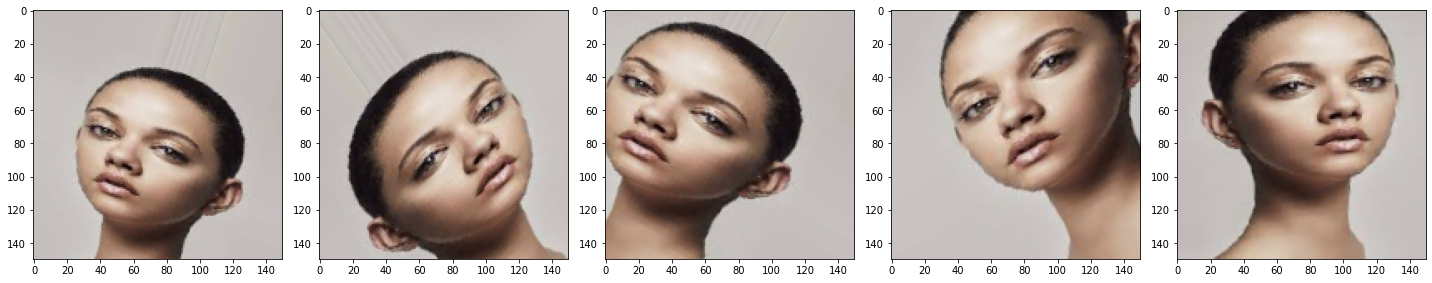

In [41]:
images = [train_data_gen[1][0][0] for i in range(5)]
plotImages(images)

In [42]:
print (predictions[1])

[0.23422739 0.76577264]


In [43]:
print(np.argmax(predictions[1]))

1


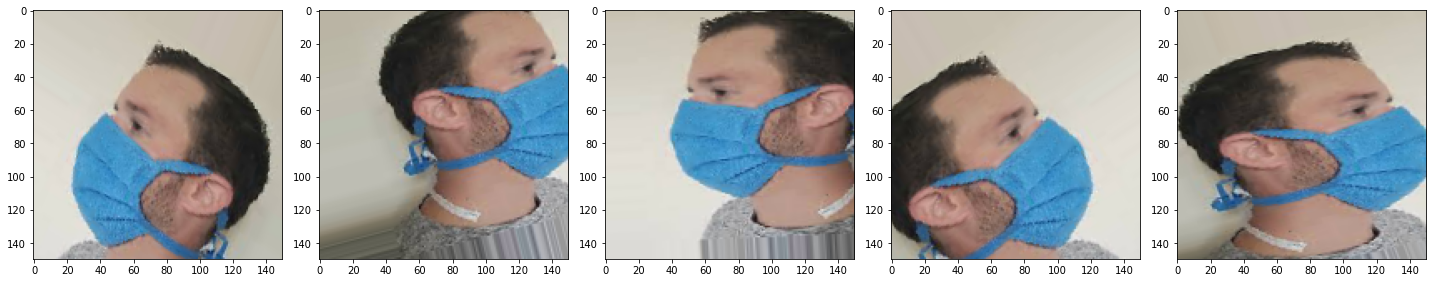

In [44]:
images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(images)

In [45]:
print(np.argmax(predictions[0]))

0


In [35]:
model.evaluate(val_data_gen)

13/13 [==============================] - 3s 201ms/step - loss: 0.2108 - accuracy: 0.9325


[0.2108338475227356, 0.9325000047683716]